# Data Reading

In [3]:
### IMPORT OF LIBRARIES ####################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow.keras as kr
from keras.metrics import AUC
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')

In [4]:
### DATA READING ####################

df_raw = pd.read_csv('online_shoppers_intention.csv')
df = df_raw.copy(deep=True)

# 2. EDA and Data Preprocessing

### 2.1 Exploratory Data Analysis

In [5]:
### GENERAL INFORMATION ####################

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12316 non-null  float64
 1   Administrative_Duration  12316 non-null  float64
 2   Informational            12316 non-null  float64
 3   Informational_Duration   12316 non-null  float64
 4   ProductRelated           12316 non-null  float64
 5   ProductRelated_Duration  12316 non-null  float64
 6   BounceRates              12316 non-null  float64
 7   ExitRates                12316 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [6]:
### MISSING VALUES ####################

df.isnull().sum()

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

In [7]:
### TARGET AND WEEKEND ANALYSIS (BOOL VARIABLES) ####################

feature_counts_df = pd.DataFrame()

for feature in df.select_dtypes(include=bool).columns:
    
    feature_counts = df[feature].value_counts()
    feature_counts_df[feature] = feature_counts
    feature_counts_df['%', feature] = round(feature_counts/len(df) * 100, 2)

feature_counts_df

,Weekend,"(%, Weekend)",Revenue,"(%, Revenue)"
False,9462,76.74,10422,84.53
True,2868,23.26,1908,15.47


"Revenue" is unbalanced, i.e. there are many more cases in the dataset where the customer generates new revenue than there are.

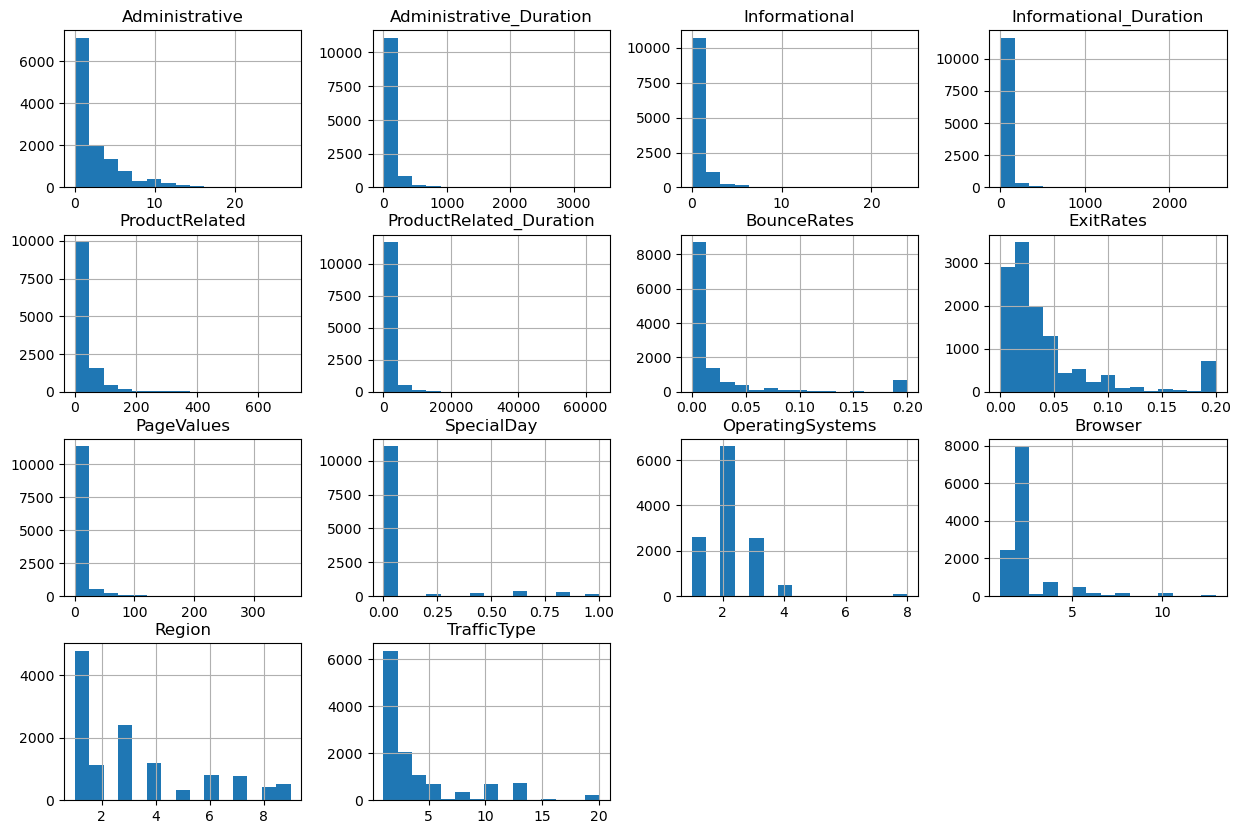

In [8]:
### NUMERICAL VARIABLES ANALYSIS ####################

# Histogram of numerical variables
num_features = df.select_dtypes(include=np.number).columns
df[num_features].hist(bins=15, figsize=(15,10))
plt.show()

In [9]:
for feature in num_features:
    print(f"Unique values {feature}: {df[feature].nunique()}")

Unique values Administrative: 27
Unique values Administrative_Duration: 3336
Unique values Informational: 17
Unique values Informational_Duration: 1259
Unique values ProductRelated: 311
Unique values ProductRelated_Duration: 9552
Unique values BounceRates: 1872
Unique values ExitRates: 4777
Unique values PageValues: 2704
Unique values SpecialDay: 6
Unique values OperatingSystems: 8
Unique values Browser: 13
Unique values Region: 9
Unique values TrafficType: 20


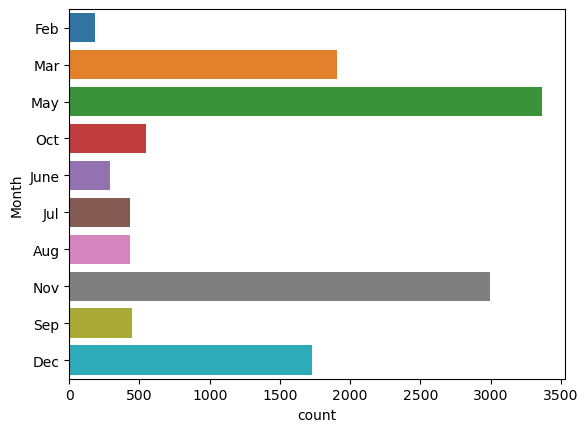

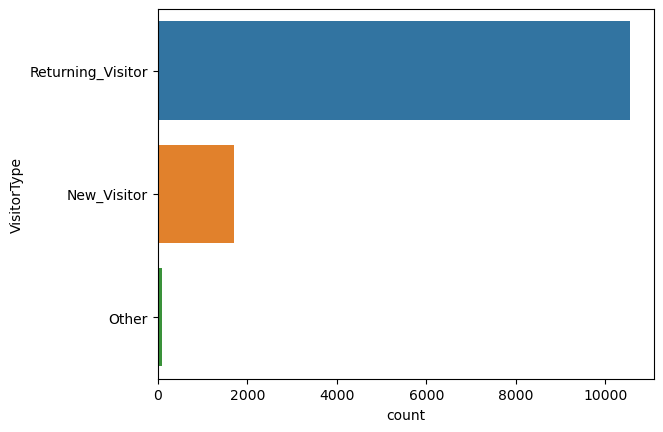

In [10]:
### CATEGORICAL VARIABLES ANALYSIS ####################

categorical_features = df.select_dtypes(include=[object]).columns
for feature in categorical_features:
    sns.countplot(y=df[feature])
    plt.show()

### Conclusions:
* There are multiple missing values.
* 85% of customers do NOT shop on the web (*Revenue*).
* 77% of customers visit the website during the week.
* Most visits are distributed between the months of *May, November, March and December* respectively. In addition, in *January and April* there is no visit data.
* Most of the visitors are old visitors (not new people). I consider eliminating the "Other" category, as it does not provide clear information and is a small fraction of the data.

### 2.2 Data Preprocessing

In [11]:
### MISSING VALUES ####################

# As we are dealing with 12330 characteristics, and have a maximum of missing values of 14, I consider that it is not necessary to
# to perform a value imputation. We use "dropna" as indicated by the statement
print(f"Shape of dataframe WITH Missing Values: {df.shape}")
df.dropna(inplace=True)
print(f"Shape of the dataframe WITHOUT Missing Values: {df.shape}")

Shape of dataframe WITH Missing Values: (12330, 18)
Shape of the dataframe WITHOUT Missing Values: (12316, 18)


In [12]:
### DELETION OF CATEGORY "OTHER" IN 'VISITORTYPE'. ####################

df = df[df['VisitorType'] != 'Other']

In [13]:
### CHANGE OF BOOL VARIABLES TO INT64 ####################

df['Weekend'] = df['Weekend'].astype('int64')
df['Revenue'] = df['Revenue'].astype('int64')

In [14]:
### CONVERSION FROM CATEGORICAL TO NUMERICAL VARIABLES ####################

# Because categorical variables have no order relation and their cardinality is low, I can
# use get_dummies from pandas for their transformation:
df_encoded = pd.get_dummies(df, columns=['Month', 'VisitorType'], drop_first=True)

In [15]:
print(f"Is df found without categorical variables: {df_encoded.select_dtypes(include='object').empty}")
print("\nDataFrame encoded:")
df_encoded.sample(5).T

Is df found without categorical variables: True

DataFrame encoded:


,9585,7285,3576,5506,5287
Administrative,12.000000,1.00,0.000000,2.000000,3.000000
Administrative_Duration,238.483333,0.00,0.000000,56.733333,30.250000
Informational,0.000000,0.00,0.000000,0.000000,0.000000
Informational_Duration,0.000000,0.00,0.000000,0.000000,0.000000
ProductRelated,13.000000,1.00,17.000000,33.000000,21.000000
ProductRelated_Duration,269.233333,17.20,391.866667,1091.394074,327.266667
BounceRates,0.000000,0.05,0.000000,0.000000,0.017391
ExitRates,0.010000,0.15,0.029412,0.003595,0.028261
PageValues,0.000000,0.00,0.000000,0.000000,68.857043
SpecialDay,0.000000,0.00,1.000000,0.000000,0.000000


In [16]:
### SPLIT INTO X + TARGET Y FEATURES ####################

X = df_encoded.drop('Revenue', axis=1)
y = df_encoded.Revenue

In [17]:
### BASIC DESCRIPTIVE ####################

df_encoded.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Returning_Visitor
count,12231.000000,12231.000000,12231.000000,12231.000000,12231.000000,12231.000000,12231.000000,12231.000000,12231.000000,12231.000000,...,12231.00000,12231.000000,12231.000000,12231.000000,12231.000000,12231.000000,12231.000000,12231.000000,12231.000000,12231.000000
mean,2.323686,81.032732,0.506255,34.664982,31.897964,1200.384922,0.022038,0.042861,5.810502,0.061925,...,0.13613,0.015044,0.035320,0.023465,0.154852,0.274957,0.243316,0.044886,0.036628,0.861499
std,3.327031,176.661037,1.273520,141.214189,44.562983,1917.440374,0.048139,0.048308,18.084786,0.199644,...,0.34294,0.121732,0.184595,0.151381,0.361779,0.446511,0.429102,0.207062,0.187855,0.345439
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,187.000000,0.000000,0.014286,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,603.707143,0.003175,0.025088,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,4.000000,93.850000,0.000000,0.000000,38.000000,1473.967424,0.016848,0.050000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
### NORMALISATION ####################

X_normalised = (X-X.mean())/X.std()
X_normalised[:2]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Returning_Visitor
0,-0.698426,-0.45869,-0.397524,-0.245478,-0.693355,-0.626035,3.696840,3.252872,-0.321292,-0.310176,...,-0.396948,8.091197,-0.191338,-0.155006,-0.428031,-0.61579,-0.567036,-0.216775,-0.194981,0.400941
1,-0.698426,-0.45869,-0.397524,-0.245478,-0.670915,-0.592657,-0.457811,1.182810,-0.321292,-0.310176,...,-0.396948,8.091197,-0.191338,-0.155006,-0.428031,-0.61579,-0.567036,-0.216775,-0.194981,0.400941


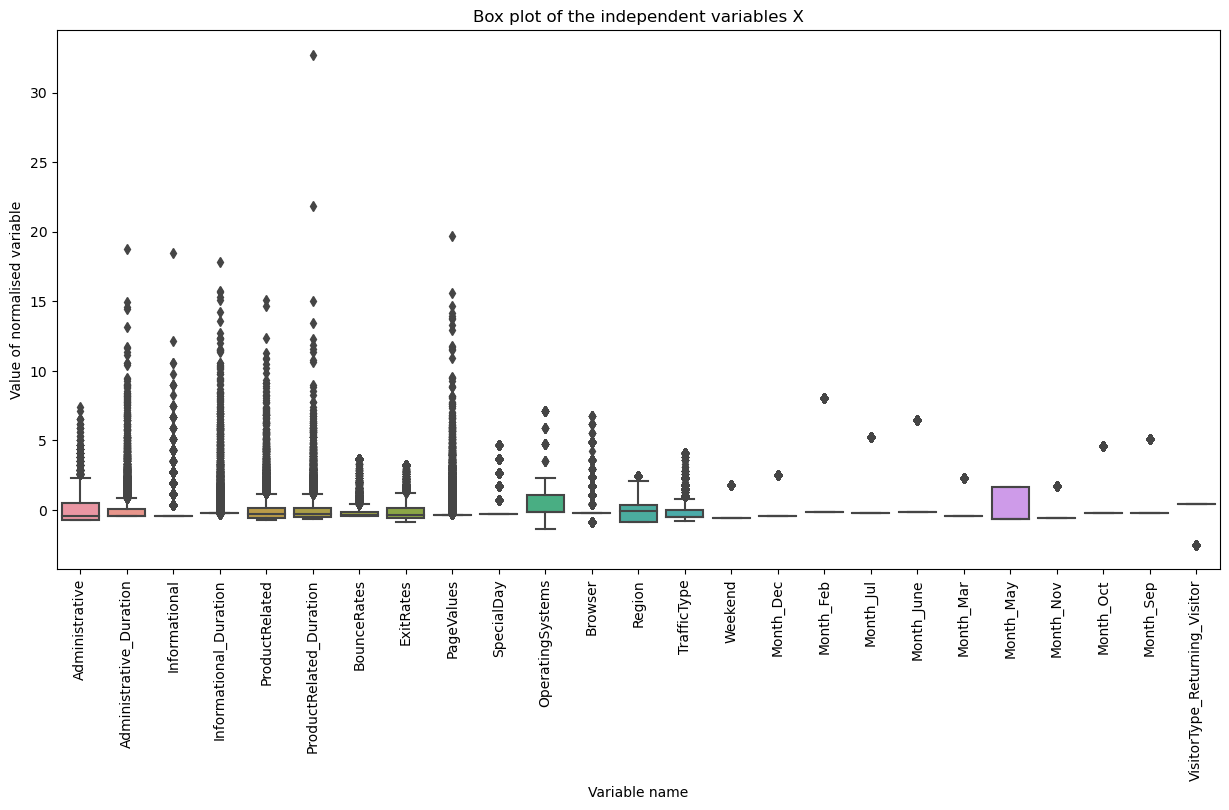

In [19]:
### DISPLAY OF OUTLIERS ####################

plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalised)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Box plot of the independent variables X')
plt.ylabel('Value of normalised variable')
_ = plt.xlabel('Variable name')

In [20]:
### ELIMINATION OF OUTLIERS ####################

Q1 = X_normalised.quantile(0.25)
Q3 = X_normalised.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = ~((X_normalised < lower_bound) | (X_normalised > upper_bound)).any(axis=1)
X = X_normalised.loc[outlier_mask.index].reset_index(drop=True)

### 2.3 Visualisations and Correlations

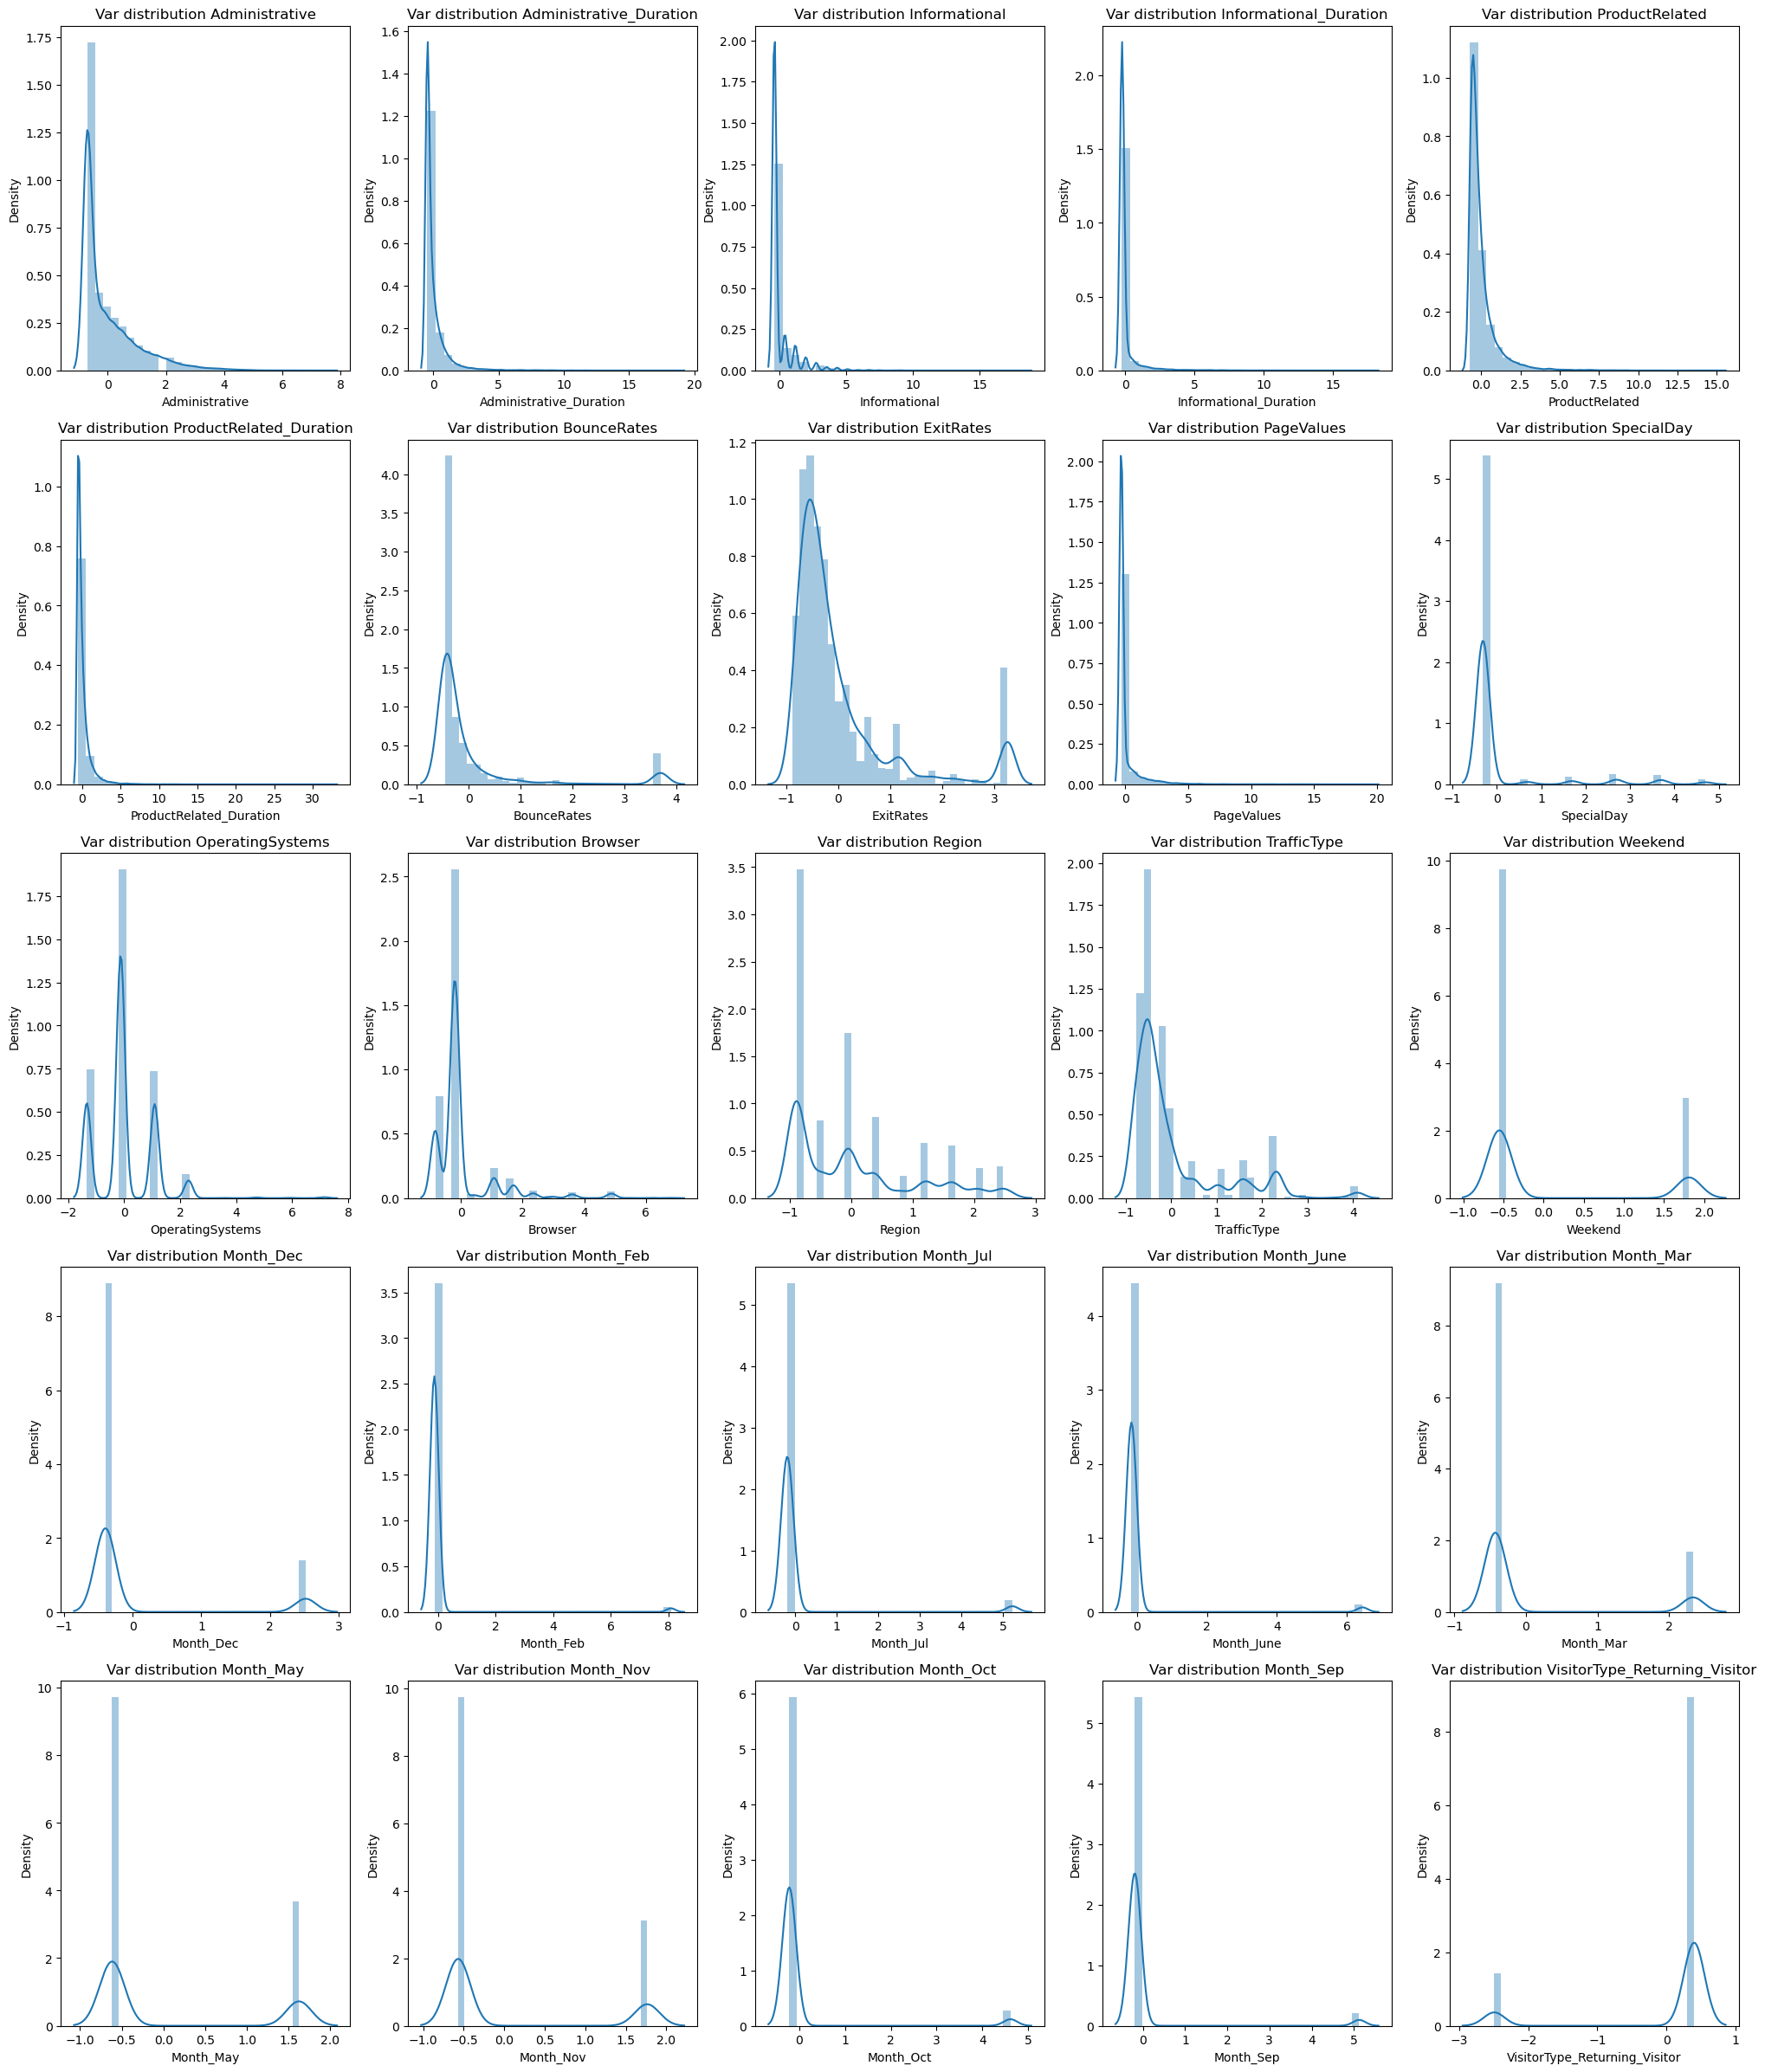

In [21]:
### HISTOGRAMS X VARIABLES ####################

plt.figure(figsize=(25,30))
n = 0
for i, column in enumerate(X.columns):
    n+=1
    plt.subplot(5, 5, n)
    sns.distplot(X[column], bins=30)
    plt.title('Var distribution {}'.format(column))
plt.show()

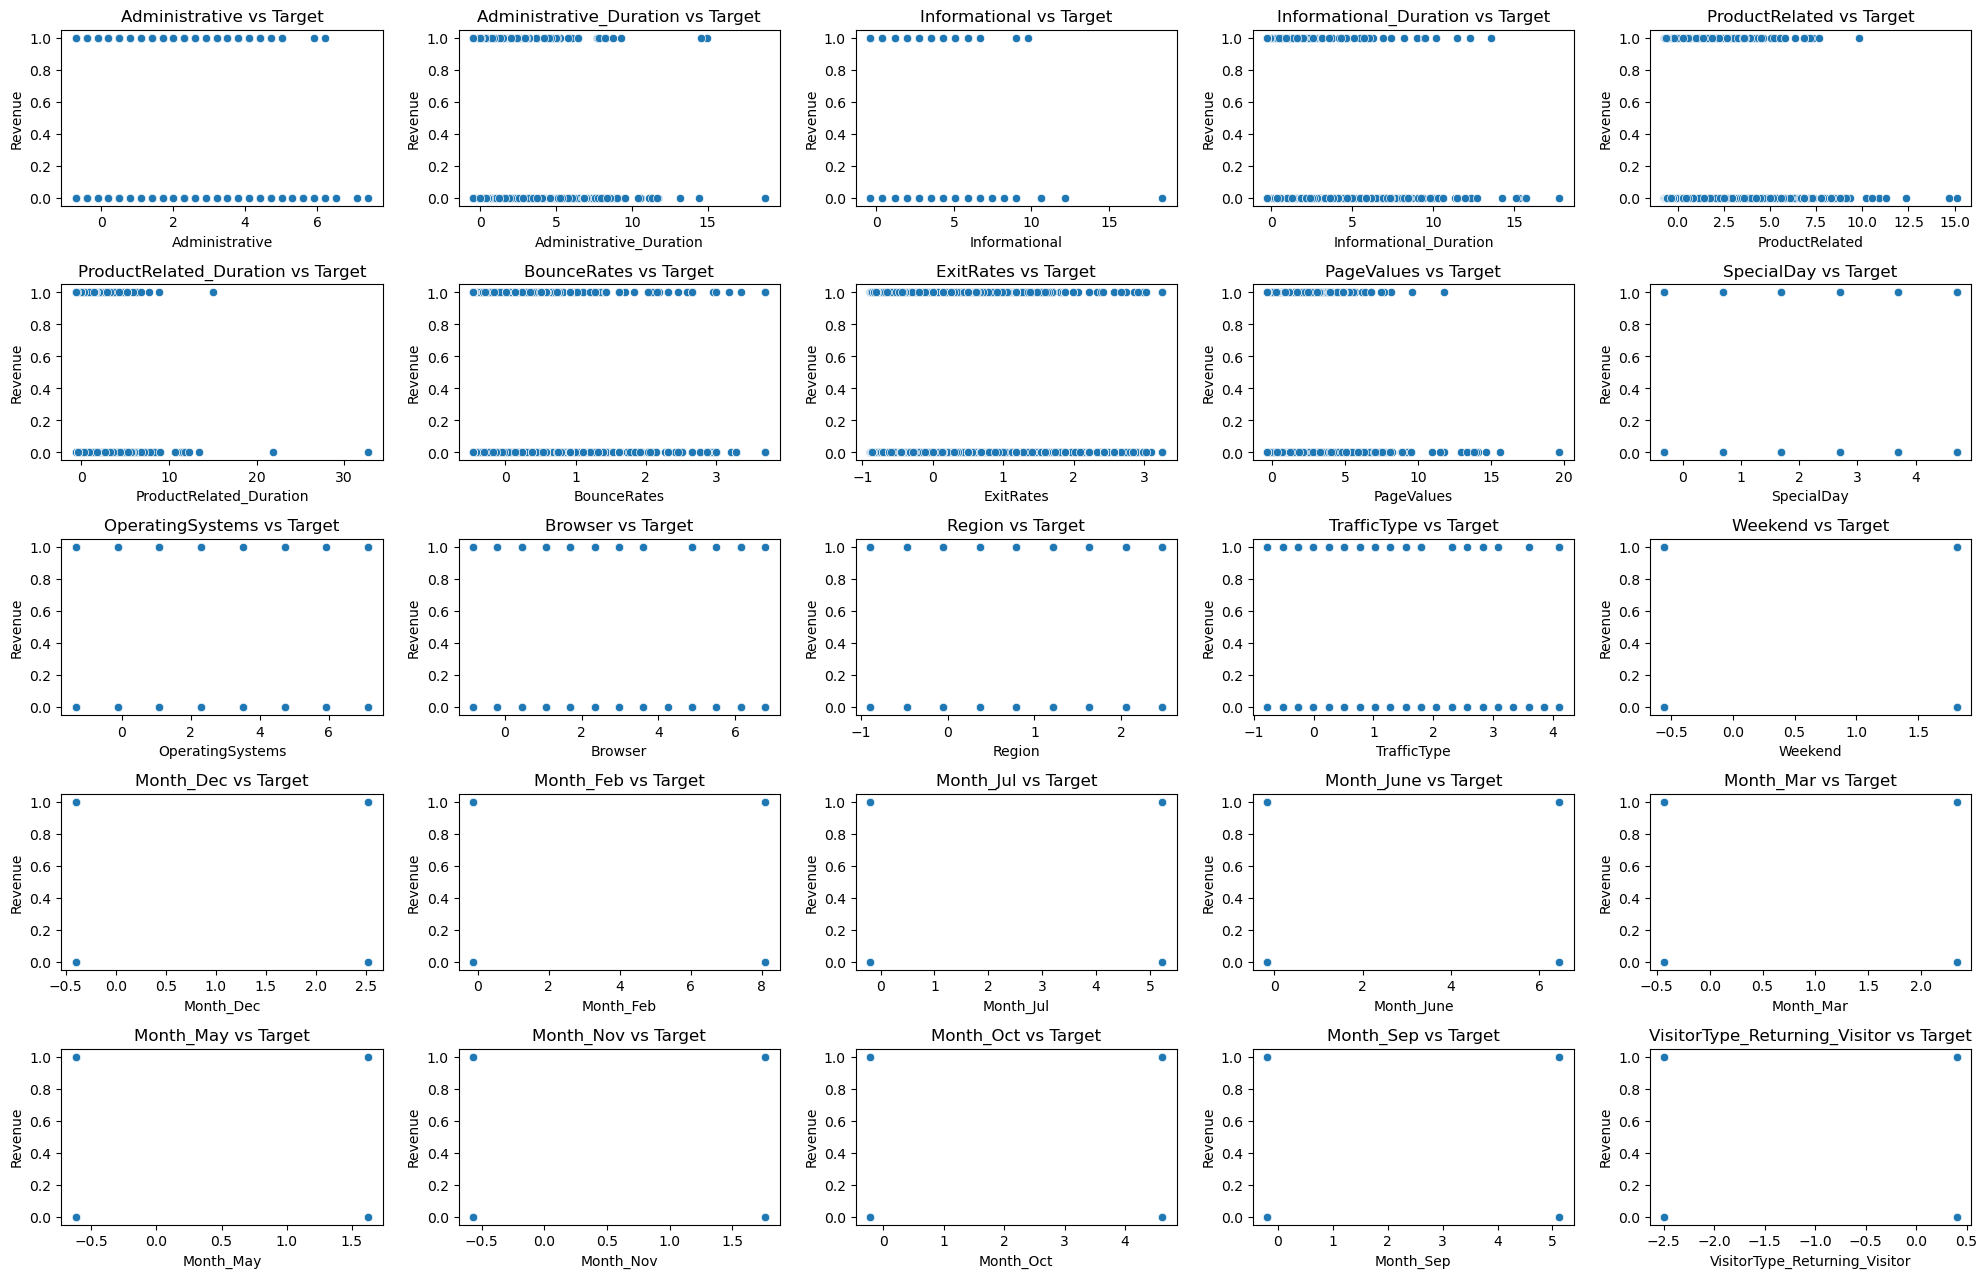

In [22]:
### RELATIONSHIP TARGET VS X VARIABLES ####################

def relations_vs_target(X, Y):
    # Number of columns in X
    num_cols = X.shape[1]

    # Adjust the size of the figure and layout
    plt.figure(figsize=(20, 15))
    rows = (num_cols // 5) + 1 # Calculate the number of rows required

    for i, col in enumerate(X.columns):
        plt.subplot(rows, 5, i + 1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title(f'{col} vs Target')
        plt.ylabel('Revenue')
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()

# Call the function with your data
relations_vs_target(X, y)

In [23]:
### CORRELATION MATRIX ####################

XY = X.copy()
XY['Revenue'] = y

correlations_matrix = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(correlations_matrix, interpolation='nearest',
                            vmin=-1., vmax=1.., vmin=-1,
                            cmap=plt.get_cmap('Blues'))))
_ = plt.title("Pearson's correlation matrix")

SyntaxError: unmatched ')' (148474988.py, line 13)

In [ ]:
correlations_target = correlations_matrix.values[ -1, : -1]
inverse_indexes = abs(correlations_target[ : ]).argsort()[ : : -1]
dictionary = {}
for name, correlation in zip( X.columns[inverse_indexes], list(correlations_target[inverse_indexes] ) ):
    dictionary[name] = correlation
pd.DataFrame.from_dict(dictionary, orient='index', columns=['Correlation with target'])

### Conclusions:

We can observe that the variables with the highest correlation with the target are the months of the year and SpecialDay, with May being the most highly correlated with a negative correlation. Even so, there are not very strong correlations.

# 3. Modeling

### 3.1. Data standardisation and Train-Test dataset splitting

In [ ]:
### STANDARDISATION OF THE DATA BEFORE ####################

scaler = StandardScaler()
X_standardised = scaler.fit_transform(X)

In [ ]:
### DIVISION INTO TRAIN AND TEST ####################

X_train, X_test, y_train, y_test = train_test_split(X_standardised, y, test_size=0.2, stratify=y, random_state=123)

### 3.2 Models

In [ ]:
### LOGISTIC REGRESSION MODEL ####################

params = {"C": [0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,0.09],
          "class_weight": ['balanced', None],
          "penalty": ['none', 'l1', 'l2', 'elasticnet']}
clf_log = LogisticRegression(solver='saga', random_state=123)
clf_log_gs = GridSearchCV(clf_log, param_grid=params, cv=5, scoring='roc_auc')
clf_log_gs.fit(X_train, y_train)

clf_log_gs_best = clf_log_gs.best_estimator_ # store the best logistic model

print(f'Best parameters for Logistic Regression: {clf_log_gs.best_params_} \n\
      ROC AUC score: {clf_log_gs.best_score_}')

# NOTE: We use 'roc_auc' as a scoring metric because it is useful when the target is unbalanced.

In [ ]:
### RANDOM FOREST MODEL ####################

params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}
clf_rf = RandomForestalClassifier(random_state=123).
clf_rf_gs = GridSearchCV(clf_rf, params, cv=5, scoring='roc_auc')
clf_rf_gs.fit(X_training, y_training)

clf_rf_gs_best = clf_rf_gs.best_estimator_ # save the best random forest model

print(f'Best parameters for Random Forest: {clf_rf_gs.best_params_}\n\
      ROC AUC score: {clf_rf_gs.best_score_}')

In [ ]:
### NEURAL NETWORK MODEL ####################

def model_builder():

    # Definition of the model
    model = kr.Secuencial([
        kr.layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
        kr.layers.Dropout(0.5),
        kr.layers.Dense(32, activation='relu'),
        kr.layers.Dropout(0.5),
        kr.layers.Dense(1, activation='sigmoid')
    ])
    # Compilation of the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC()])
    return model

In [ ]:
clf_rrnn = model_builder()

early_stopping = kr.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

historical = clf_rrnn.fit(X_train, y_train, epochs=100, batch_size=32, 
                      validation_split=0.2, verbose=0, callbacks=[early_stopping])

An object with the neural network training has been stored in the history. The progress of the training can be visualised by accessing its metrics and the loss saved with the ".history" attribute.

In [ ]:
hist = pd.DataFrame(historical.history)
hist['epoch'] = historical.epoch
hist.tail()

In [ ]:
# Analyse the evolution of the neural network

# Plot the loss
plt.plot(historical.history['loss'], label='Training Loss')
plt.plot(historical.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the AUC
plt.plot(historical.history['auc'], label='Training AUC')
plt.plot(historical.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [ ]:
# Get the probability predictions
y_pred_proba_rrnn = clf_rrnn.predict(X_test).ravel()

# Calculate the ROC AUC
roc_auc_rrnn = roc_auc_score(y_test, y_pred_proba_rrnn)
print(f'ROC AUC score for neural network: {roc_auc_rrnn}')

In [ ]:
### RRNN MODEL IN CASE YOU WANT TO USE GRIDSEARCHCV ####################################

clf_rrnn = KerasClassifier(build_fn=model_builder, verbose=0) # Create KerasClassifier

params = {
    'epochs': [50, 100],
    'batch_size': [16, 32]
}

clf_rrnn_gr = GridSearchCV(clf_rrnn, params, cv=5, scoring=“roc_auc”, n_jobs=-1)
clf_rrnn_gr.fit(X_train, y_train, callbacks=[early_stopping])
clf_rrnn_best = clf_rrnn_gr.best_estimator_

print(f'Best Parameters for Neural Networks with GridSearchCV: {clf_rrnn_gr.best_params_}\n\
      ROC AUC score: {clf_rrnn_gr.best_score_}')

### 3.3 Best model selection and prediction

In [ ]:
### BEST MODEL ACCORDING TO ROC AUC ####################

''' We compare the ROC AUC of the models and select which one is the best:
    ROC AUC Logistic AUC -> 0.9050654514006785
    ROC AUC Random Forest -> 0.9284345644378652
    ROC AUC Neural Networks -> 0.9196335158694109
    ROC AUC RRNN with GridSearch -> 0.9236703457476223

    The best model will be the one that has the highest score, in this case the
    Random Forest model.
'''
# That is, in this form:
# best_model = clf_rf_gs_gs_best


# However, let's apply CrossValidation
cv_scores_logistic = cross_val_score(clf_log_gs_best, X_train, y_train, cv=5, scoring='roc_auc')
cv_scores_rf = cross_val_score(clf_rf_gs_best, X_train, y_train, cv=5, scoring='roc_auc')
cv_scores_rrnn = cross_val_score(clf_rrnn_best, X_train, y_train, cv=5, scoring='roc_auc')

# Average ROC-AUC scores with CrossValidation
mean_cv_score_logistic = np.mean(cv_scores_logistic)
mean_cv_score_rf = np.mean(cv_scores_rf)
mean_cv_score_rrnn = np.mean(cv_scores_rrnn)

model_scores = {
    "Logistic Regression": (mean_cv_score_logistic, clf_log_gs_best),
    "Random Forest": (mean_cv_score_rf, clf_rf_gs_best),
    "RRNNN": (mean_cv_score_rrnn, clf_rrnn_best)
}

# Find the name of the model with the highest score and the model itself
best_model_name = max(model_scores, key=lambda x: model_scores[x][0])
best_model = model_scores[best_model_name][1]

# Print the results
print("Maximum ROC-AUC score is:", model_scores[best_model_name][0])
print("The model with the maximum ROC-AUC score is:", best_model_name)
print("The model object is:", best_model)


In [ ]:
### FINAL PREDICTION ON TEST SET ######################################

y_test_pred_prob = best_model.predict_proba(X_test)[:,1]

## 3.4. ROC-AUC plot and Ranking Metrics

In [ ]:
### ROC-AUC plot and Ranking Metrics ##########################################

# Display the ROC curve and the best threshold location
fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_pred_prob)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, "b", label = "AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], colour="red", linestyle="--")
plt.scatter(fpr, tpr, marker="o", color="black", label="Best threshold")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# Rating metrics
y_thresholded = [1 if y > 0.6 else 0 for y in y_test_pred_prob] # Adjust the threshold
report = metrics.classification_report(y_test, y_thresholded)
conf_matrix = metrics.confusion_matrix(y_test, y_thresholded)
accuracy = metrics.accuracy_score(y_test, y_thresholded)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:{conf_matrix}')
print(f'Classification Report:{report}')

# 4. CONCLUTIONS

***ROC-AUC:***
The AUC is 0.94, indicating that our model excellently differentiates between positive and negative cases.

* ***Accuracy:***
The accuracy of 90.6% shows that the model classifies instances correctly most of the time. However, accuracy alone can be misleading (especially in cases like this where class imbalance exists).

***Confusion Matrix:***
Most cases are classified as True Negatives. There are some false negatives and false positives, but they are relatively low.

***Classification Report:***
The lower **sensitivity** (0.48) for class 1 (income generating) indicates that the model misses a significant part of the positive cases. This could be due to a class imbalance in which sessions without income are more frequent than sessions with income (support class0 = 2068 vs class1 = 379).
The **precision** for class 1 is relatively high (0.84), suggesting that when the model predicts revenue generation, it tends to be right.